In [1]:
# !pip install oolearning --upgrade

In [2]:
import copy
import os
import oolearning as oo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from helpers import column_log, BinaryAucRocScore

pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

In [3]:
csv_file = '../census.csv'
target_variable = 'income'

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                   target_variable=target_variable)
negative_class = '<=50K'
positive_class = '>50K'

explore.dataset.head(20)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [4]:
def create_net_capital(x):
    temp = x.copy()
    temp['net capital'] = temp['capital-gain'] - temp['capital-loss']
    return temp

In [5]:
global_transformations = [oo.ImputationTransformer(),
                          oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                                                        custom_function=column_log),
                          oo.StatelessTransformer(custom_function=create_net_capital),
                          oo.CenterScaleTransformer(),
                          oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)]

In [6]:
params_dict = dict(
#    max_depth=[3, 4],
#    min_child_weight=5,
#    gamma=[0, 0.15, 0.3],
    #subsample=[0.99, 1.0],
    #colsample_bytree=[0.30, 0.35, 0.40, 0.45, 0.5, 0.55],
   # reg_alpha=[0, 0.01, 0.25, 0.05],
   # reg_lambda=[1.5, 2, 2.5],
    #scale_pos_weight=scale_pos_weight_calc,
    learning_rate=[0.04, 0.045, 0.05, 0.055],
    n_estimators=[2500, 2750, 3000, 3250],

)
grid = oo.HyperParamsGrid(params_dict=params_dict)
grid.params_grid

,learning_rate,n_estimators
0,0.040,2500
1,0.040,2750
2,0.040,3000
3,0.040,3250
4,0.045,2500
5,0.045,2750
6,0.045,3000
7,0.045,3250
8,0.050,2500
9,0.050,2750


In [7]:
n_positive = np.sum(explore.dataset[target_variable] == positive_class)
n_negative = np.sum(explore.dataset.income == negative_class)
scale_pos_weight_calc = n_negative / n_positive
scale_pos_weight_calc

3.034796573875803

In [8]:
hyper_param_object = oo.XGBoostTreeHP(
                                objective=oo.XGBObjective.BINARY_LOGISTIC,
                                learning_rate=0.1,
                                n_estimators=1000,
                                max_depth=3,
                                min_child_weight=5,
                                gamma=0.15,
                                subsample=1,
                                colsample_bytree=0.4,
                                reg_alpha=0,
                                reg_lambda=2,
                                scale_pos_weight=scale_pos_weight_calc,)

In [9]:
model=oo.XGBoostClassifier()

In [10]:
repeats = 5
folds = 5

In [11]:
model_cache_directory = 'tuner_XGB'
resampler_cache_directory = 'tuner_XGB_resample_cache'

In [12]:
score_list = [oo.AucRocScore(positive_class=positive_class),
              oo.FBetaScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                    positive_class=positive_class),
                            beta=0.5),
              oo.SensitivityScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                          positive_class=positive_class)),
              oo.PositivePredictiveValueScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                                      positive_class=positive_class))]

In [13]:

# define/configure the resampler
resampler = oo.RepeatedCrossValidationResampler(model=model,  # using a Random Forest model
                                             transformations=global_transformations,
                                             scores=[s.clone() for s in score_list],
                                             folds=folds,
                                             repeats=repeats)
# define/configure the ModelTuner
tuner = oo.ModelTuner(resampler=resampler,
                      hyper_param_object=hyper_param_object,
                      model_persistence_manager=oo.LocalCacheManager(cache_directory=model_cache_directory),
                      resampler_persistence_manager=oo.LocalCacheManager(cache_directory=resampler_cache_directory),
                      parallelization_cores=-1,
                      #parallelization_cores=0,
                     )

In [14]:
tuner.tune(data_x=explore.dataset.drop(columns=target_variable),
           data_y=explore.dataset[target_variable],
           params_grid=grid)

In [15]:
tuner.results.best_hyper_params

{'learning_rate': 0.045, 'n_estimators': 3000}

In [16]:
params_dict

{'learning_rate': [0.04, 0.045, 0.05, 0.055],
 'n_estimators': [2500, 2750, 3000, 3250]}

In [17]:
tuner.results.best_model_resampler_object.score_means

{'AUC_ROC': 0.929568975930517,
 'F_BETA': 0.6551097944387684,
 'sensitivity': 0.8666750853195937,
 'positive_predictive_value': 0.6174425178208235}

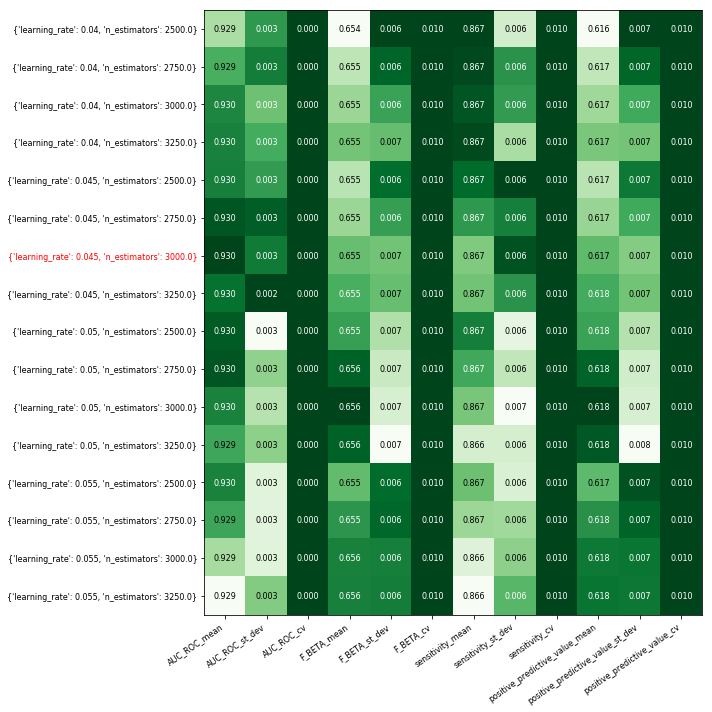

In [18]:
tuner.results.plot_resampled_stats()

In [29]:
tuner.results.resampled_stats

,learning_rate,n_estimators,AUC_ROC_mean,AUC_ROC_st_dev,AUC_ROC_cv,F_BETA_mean,F_BETA_st_dev,F_BETA_cv,sensitivity_mean,sensitivity_st_dev,sensitivity_cv,positive_predictive_value_mean,positive_predictive_value_st_dev,positive_predictive_value_cv
0,0.040,2500,0.929440,0.002510,0.0,0.654232,0.006141,0.01,0.867337,0.006373,0.01,0.616384,0.006590,0.01
1,0.040,2750,0.929492,0.002506,0.0,0.654704,0.006248,0.01,0.867319,0.005910,0.01,0.616909,0.006707,0.01
2,0.040,3000,0.929525,0.002518,0.0,0.654883,0.006492,0.01,0.867271,0.005940,0.01,0.617114,0.006995,0.01
3,0.040,3250,0.929528,0.002513,0.0,0.655067,0.006618,0.01,0.867308,0.006246,0.01,0.617315,0.007141,0.01
4,0.045,2500,0.929530,0.002511,0.0,0.654727,0.006275,0.01,0.867186,0.005659,0.01,0.616951,0.006784,0.01
5,0.045,2750,0.929558,0.002501,0.0,0.654882,0.006475,0.01,0.866961,0.005839,0.01,0.617153,0.006997,0.01
6,0.045,3000,0.929569,0.002505,0.0,0.655110,0.006649,0.01,0.866675,0.005703,0.01,0.617443,0.007192,0.01
7,0.045,3250,0.929540,0.002498,0.0,0.655239,0.006625,0.01,0.866726,0.005910,0.01,0.617580,0.007138,0.01
8,0.050,2500,0.929555,0.002538,0.0,0.655345,0.006833,0.01,0.867093,0.006450,0.01,0.617651,0.007347,0.01
9,0.050,2750,0.929559,0.002521,0.0,0.655739,0.006911,0.01,0.866884,0.006313,0.01,0.618116,0.007460,0.01


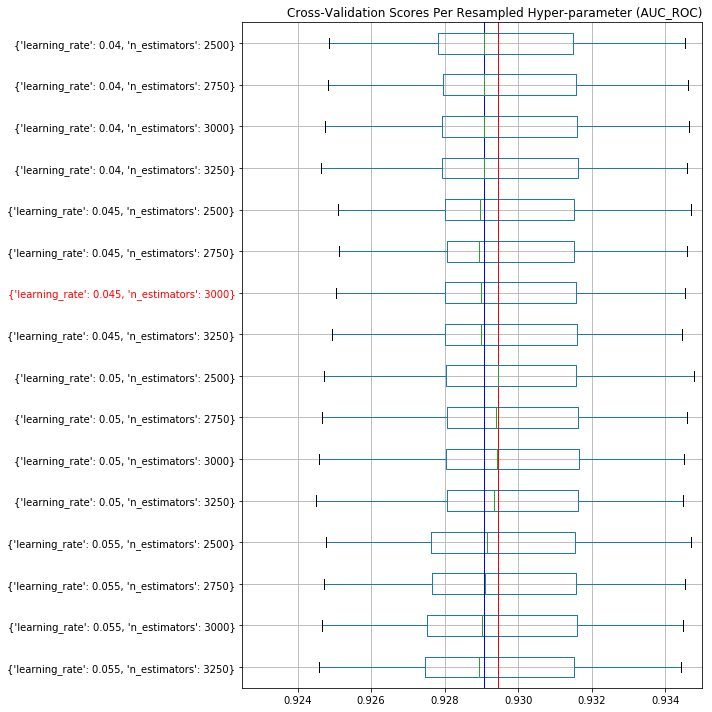

In [19]:
tuner.results.plot_resampled_scores(metric=oo.Metric.AUC_ROC,
                                    x_axis_limits=(0.9225, 0.935),
                                    show_one_ste_rule=True
                                   )

In [20]:
tuner.results.resampled_stats

,learning_rate,n_estimators,AUC_ROC_mean,AUC_ROC_st_dev,AUC_ROC_cv,F_BETA_mean,F_BETA_st_dev,F_BETA_cv,sensitivity_mean,sensitivity_st_dev,sensitivity_cv,positive_predictive_value_mean,positive_predictive_value_st_dev,positive_predictive_value_cv
0,0.040,2500,0.929440,0.002510,0.0,0.654232,0.006141,0.01,0.867337,0.006373,0.01,0.616384,0.006590,0.01
1,0.040,2750,0.929492,0.002506,0.0,0.654704,0.006248,0.01,0.867319,0.005910,0.01,0.616909,0.006707,0.01
2,0.040,3000,0.929525,0.002518,0.0,0.654883,0.006492,0.01,0.867271,0.005940,0.01,0.617114,0.006995,0.01
3,0.040,3250,0.929528,0.002513,0.0,0.655067,0.006618,0.01,0.867308,0.006246,0.01,0.617315,0.007141,0.01
4,0.045,2500,0.929530,0.002511,0.0,0.654727,0.006275,0.01,0.867186,0.005659,0.01,0.616951,0.006784,0.01
5,0.045,2750,0.929558,0.002501,0.0,0.654882,0.006475,0.01,0.866961,0.005839,0.01,0.617153,0.006997,0.01
6,0.045,3000,0.929569,0.002505,0.0,0.655110,0.006649,0.01,0.866675,0.005703,0.01,0.617443,0.007192,0.01
7,0.045,3250,0.929540,0.002498,0.0,0.655239,0.006625,0.01,0.866726,0.005910,0.01,0.617580,0.007138,0.01
8,0.050,2500,0.929555,0.002538,0.0,0.655345,0.006833,0.01,0.867093,0.006450,0.01,0.617651,0.007347,0.01
9,0.050,2750,0.929559,0.002521,0.0,0.655739,0.006911,0.01,0.866884,0.006313,0.01,0.618116,0.007460,0.01


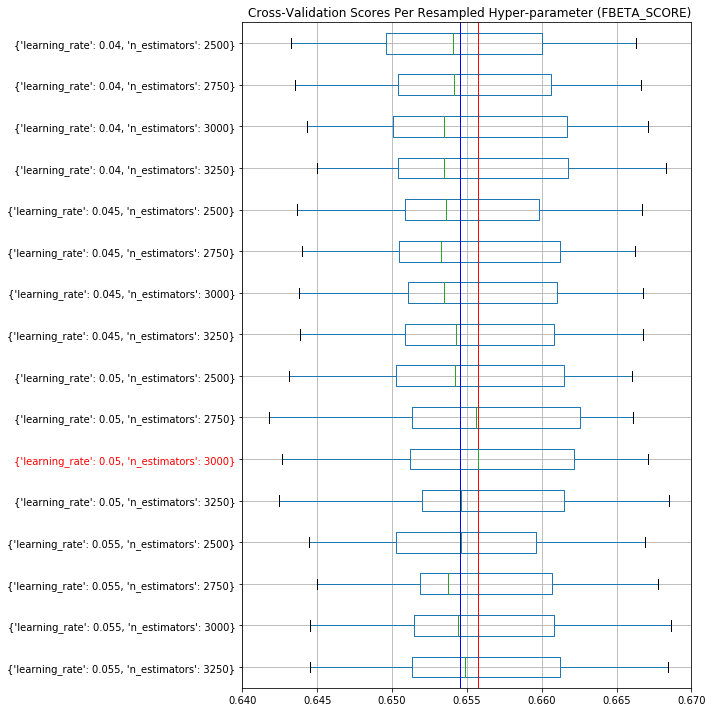

In [21]:
tuner.results.plot_resampled_scores(oo.Metric.FBETA_SCORE,
                                    x_axis_limits=(0.64, 0.67),
                                    show_one_ste_rule=True
                                   )

In [22]:
params_dict

{'learning_rate': [0.04, 0.045, 0.05, 0.055],
 'n_estimators': [2500, 2750, 3000, 3250]}

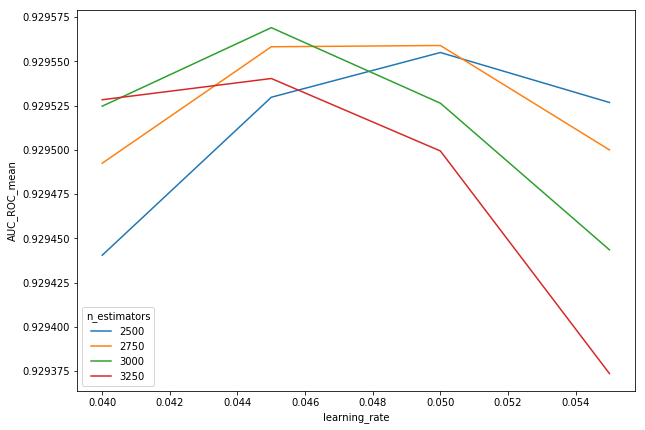

In [23]:
tuner.results.plot_hyper_params_profile(
                                        metric=oo.Metric.AUC_ROC,
                                        x_axis='learning_rate',
                                        line='n_estimators',
                                       # grid='gamma'
                                       )

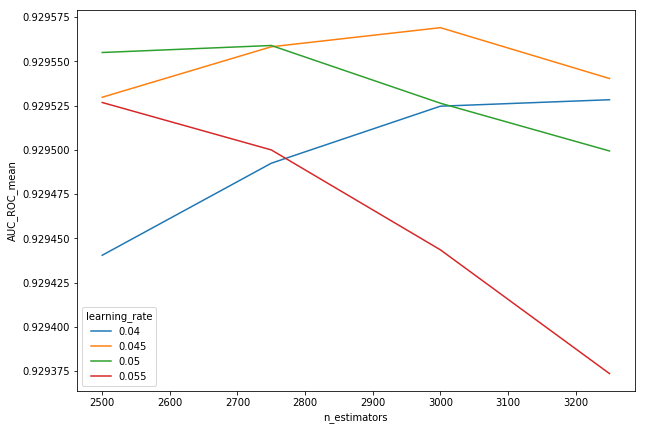

In [30]:
tuner.results.plot_hyper_params_profile(
                                        metric=oo.Metric.AUC_ROC,
                                        x_axis='n_estimators',
                                        line='learning_rate',
                                       # grid='gamma'
                                       )

In [24]:
tuner.results.best_hyper_params

{'learning_rate': 0.045, 'n_estimators': 3000}

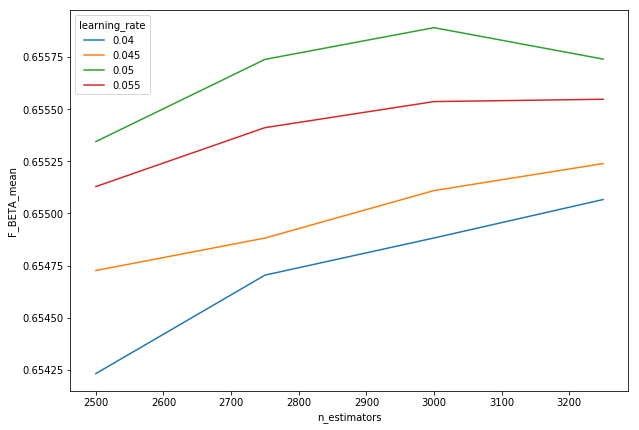

In [25]:
tuner.results.plot_hyper_params_profile(
                                        metric=oo.Metric.FBETA_SCORE,
                                        x_axis='n_estimators',
                                        line='learning_rate',
                                       # grid='gamma'
                                       )

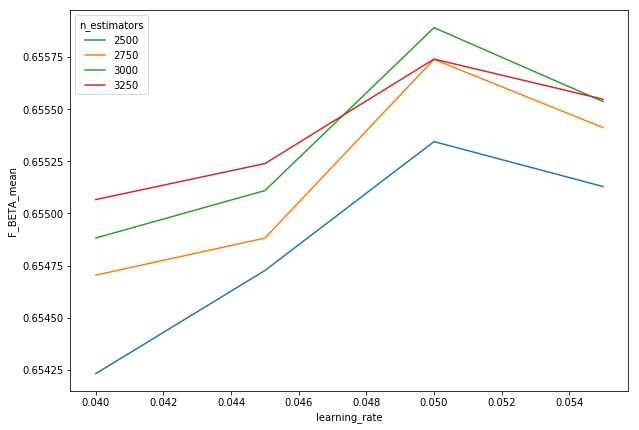

In [31]:
tuner.results.plot_hyper_params_profile(
                                        metric=oo.Metric.FBETA_SCORE,
                                        x_axis='learning_rate',
                                        line='n_estimators',
                                       # grid='gamma'
                                       )

In [32]:
tuner.results.best_hyper_params

{'learning_rate': 0.045, 'n_estimators': 3000}

Chose `{'learning_rate': 0.05, 'n_estimators': 2500}`

seems more stable, less complex model

In [ ]:
assert False

# Final Train

In [33]:
final_hyper_param_object = oo.XGBoostTreeHP(
                                objective=oo.XGBObjective.BINARY_LOGISTIC,
                                learning_rate=0.05,
                                n_estimators=2500,
                                max_depth=3,
                                min_child_weight=5,
                                gamma=0.15,
                                subsample=1,
                                colsample_bytree=0.4,
                                reg_alpha=0,
                                reg_lambda=2,
                                scale_pos_weight=scale_pos_weight_calc,)



final_model = oo.XGBoostClassifier()
final_transformations = [
                         # kaggle test file has white space around values
                         oo.StatelessColumnTransformer(columns=explore.categoric_features,
                                                       custom_function=lambda x: x.str.strip()),
                         oo.ImputationTransformer(),
                         oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                                                       custom_function=column_log),
                         oo.StatelessTransformer(custom_function=create_net_capital),
                         oo.CenterScaleTransformer(),
                         oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)
]

In [34]:
evaluator = oo.TwoClassProbabilityEvaluator(converter=
                    oo.TwoClassThresholdConverter(positive_class=positive_class))

trainer = oo.ModelTrainer(model=final_model.clone(),
                          model_transformations=[t.clone() for t in final_transformations],
                          splitter=None,  # don't split, train on all data
                          evaluator=evaluator,
                          scores=[s.clone() for s in score_list])
trainer.train(data=explore.dataset, target_variable=target_variable, hyper_params=final_hyper_param_object.clone())

trainer.training_evaluator.all_quality_metrics

{'AUC ROC': 0.9381262575908724,
 'AUC Precision/Recall': 0.8513116093038335,
 'Kappa': 0.6266435762410425,
 'F1 Score': 0.7347967962029073,
 'Two-Class Accuracy': 0.8418468886824997,
 'Error Rate': 0.15815311131750034,
 'True Positive Rate': 0.8840114204139901,
 'True Negative Rate': 0.8279531957429294,
 'False Positive Rate': 0.1720468042570706,
 'False Negative Rate': 0.11598857958601,
 'Positive Predictive Value': 0.6286802030456853,
 'Negative Predictive Value': 0.9558753648767905,
 'Prevalence': 0.2478439697492371,
 'No Information Rate': 0.7521560302507629,
 'Total Observations': 45222}

In [35]:
trainer.training_scores[0].value

0.9381262575908724

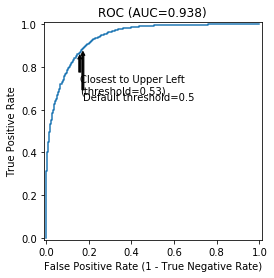

In [36]:
trainer.training_evaluator.plot_roc_curve()

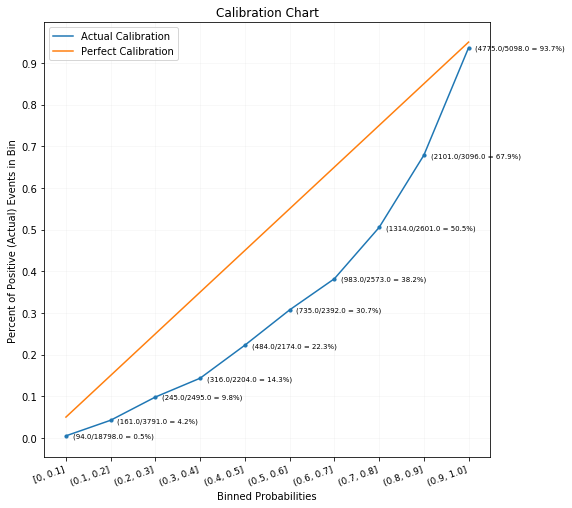

In [37]:
trainer.training_evaluator.plot_calibration()

In [38]:
csv_file = '../test_census.csv'
test_dataset = pd.read_csv(csv_file)
test_dataset.shape

(45222, 14)

In [39]:
test_dataset.head(100)

,Unnamed: 0,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0,21.0,Private,10th,6.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
1,1,49.0,Private,Bachelors,13.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,0.0,0.0,40.0,United-States
2,2,44.0,Self-emp-not-inc,Assoc-acdm,12.0,Married-civ-spouse,Other-service,Wife,White,Female,0.0,0.0,99.0,United-States
3,3,34.0,Private,Bachelors,13.0,Married-civ-spouse,Sales,Husband,White,Male,7298.0,0.0,46.0,United-States
4,4,24.0,Private,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
5,5,52.0,Private,7th-8th,4.0,Divorced,Priv-house-serv,Own-child,Black,Female,0.0,0.0,16.0,United-States
6,6,61.0,Private,7th-8th,4.0,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,50.0,United-States
7,7,24.0,Private,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
8,8,30.0,Private,HS-grad,9.0,Never-married,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,22.0,United-States
9,9,42.0,Local-gov,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States


In [40]:
indexes = test_dataset['Unnamed: 0']
predictions = trainer.predict(test_dataset.drop(columns='Unnamed: 0'))
predictions.head()

,<=50K,>50K
0,0.928181,0.071819
1,0.099676,0.900324
2,0.570999,0.429001
3,0.000161,0.999839
4,0.891305,0.108695


In [41]:
income_value = predictions['>50K']
new_predictions = pd.DataFrame({'id': indexes, 'income': income_value})
new_predictions.to_csv('submission_9_xgb.csv', index=False)

In [ ]:
# # e.g. lower threshold will change 0's to 1's so new - previous will give number predictions that changed to 1
# difference = new_predictions.income - previous_predictions.income
# difference.sum() / len(difference)

# Results

## 2)

Kaggle Public: `0.85769`

File: `submission_5_xgb`

ROC Threshold: `0.51`

Parameters:

```
objective=oo.XGBObjective.BINARY_LOGISTIC,
learning_rate=0.05,
n_estimators=1750,
max_depth=4,
min_child_weight=2,
gamma=0.1,
subsample=1.0,
colsample_bytree=0.15,
reg_alpha=0.005,
scale_pos_weight=scale_pos_weight_calc
```

Originally had Mean Resampler Results of:

```
{'BINARY_AUC': 0.8457153054881816,
 'AUC_ROC': 0.9297213921879113,
 'F_BETA': 0.6565762775126679,
 'sensitivity': 0.8673808546152647,
 'positive_predictive_value': 0.6189823694407532}
```


## 3)

Kaggle Public: `0.85864`

File: `submission_6_xgb`

ROC Threshold: `0.49`

Parameters:

```
objective=oo.XGBObjective.BINARY_LOGISTIC,
learning_rate=0.05,
n_estimators=1750,
max_depth=4,
min_child_weight=2,
gamma=0.1,
subsample=1.0,
colsample_bytree=0.15,
reg_alpha=0.005,
scale_pos_weight=scale_pos_weight_calc
```

Originally had Mean Resampler Results of:

```
{'BINARY_AUC': 0.8457153054881816,
 'AUC_ROC': 0.9297213921879113,
 'F_BETA': 0.6565762775126679,
 'sensitivity': 0.8673808546152647,
 'positive_predictive_value': 0.6189823694407532}
```


----

**NOTE: I realized it doesn't make sense to use 0's and 1's with AUC so I submitted raw probabilities and my score shot up.**

## 4) Using Probabilities

Kaggle Public: `0.93693`

File: `submission_7_xgb`

Parameters:

```
objective=oo.XGBObjective.BINARY_LOGISTIC,
learning_rate=0.05,
n_estimators=2000,
max_depth=3,
min_child_weight=2,
gamma=0.1,
subsample=0.95,
colsample_bytree=0.15,
reg_alpha=0.01,
reg_lambda=2,
scale_pos_weight=scale_pos_weight_calc,
```

Originally had Mean Resampler Results of:

```
{'BINARY_AUC': 0.8452782933202593,
 'AUC_ROC': 0.9292918569630045,
 'F_BETA': 0.655544556494659,
 'sensitivity': 0.8673600361173268,
 'positive_predictive_value': 0.6178407865646417}
```


## 5) Using Probabilities

Kaggle Public: `0.`

File: `submission_9_xgb.csv`

Parameters:

```
objective=oo.XGBObjective.BINARY_LOGISTIC,
learning_rate=0.05,
n_estimators=2500,
max_depth=3,
min_child_weight=5,
gamma=0.15,
subsample=1,
colsample_bytree=0.4,
reg_alpha=0,
reg_lambda=2,
scale_pos_weight=scale_pos_weight_calc,)

```

Originally had Mean Resampler Results of:

```
{'AUC_ROC': 0.929568975930517,
 'F_BETA': 0.6551097944387684,
 'sensitivity': 0.8666750853195937,
 'positive_predictive_value': 0.6174425178208235}
```
